# Computational Final Project

## Setup and Imports

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min



## Loading and Preprocessing the Data

In [2]:
data = pd.read_csv("../data/fake reviews dataset.csv")

data.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...


In [3]:
data.dtypes

category    object
rating       int64
label       object
text_       object
dtype: object

In [22]:
data.summary()

AttributeError: 'DataFrame' object has no attribute 'summary'

## Feature Engineering

#### Text-based Features
1 - Text Length: Calculate the length of each review.
2 - Sentiment Score: You could use TextBlob to get the sentiment score.

In [4]:
from textblob import TextBlob

# Feature: Text length
data['text_length'] = data['text_'].apply(len)

# Feature: Sentiment score
data['sentiment_score'] = data['text_'].apply(lambda x: TextBlob(x).sentiment.polarity)


##### Summary of text_length and sentiment_score in Anomaly Detection

High Variability in Genuine Reviews: Original (OG) reviews are likely to vary in both text_length and sentiment_score, as they reflect diverse user experiences.

Patterns in Fake Reviews: Fake (CG) reviews might follow patterns, such as being consistently short, overly positive, or similarly structured, which these features can capture.

Detecting Anomalies: Using both text_length and sentiment_score as features helps anomaly detection models (like Isolation Forest) spot reviews that deviate from the natural distribution of genuine reviews.

These features are therefore essential as they capture both structural (text length) and emotional (sentiment) aspects of the reviews, allowing for a nuanced approach to detecting computer-generated reviews.

#### Rating-based Features
1 - Rating Deviation: Calculate the deviation of each rating from the average rating for that category

In [5]:
# Calculate the mean rating per category
category_avg_rating = data.groupby('category')['rating'].transform('mean')

# Feature: Rating deviation
data['rating_deviation'] = data['rating'] - category_avg_rating


#### Category Encoding
Encode the category column to use in the model.

In [6]:
# One-hot encoding for category
data = pd.get_dummies(data, columns=['category'], drop_first=True)


#### Final Feature Set

In [7]:
# Prepare the feature set for anomaly detection
features = data[['text_length', 'sentiment_score', 'rating', 'rating_deviation'] + [col for col in data.columns if col.startswith('category_')]]


## Standardize the Data
Standardize the feature data for improved model performance.

In [8]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


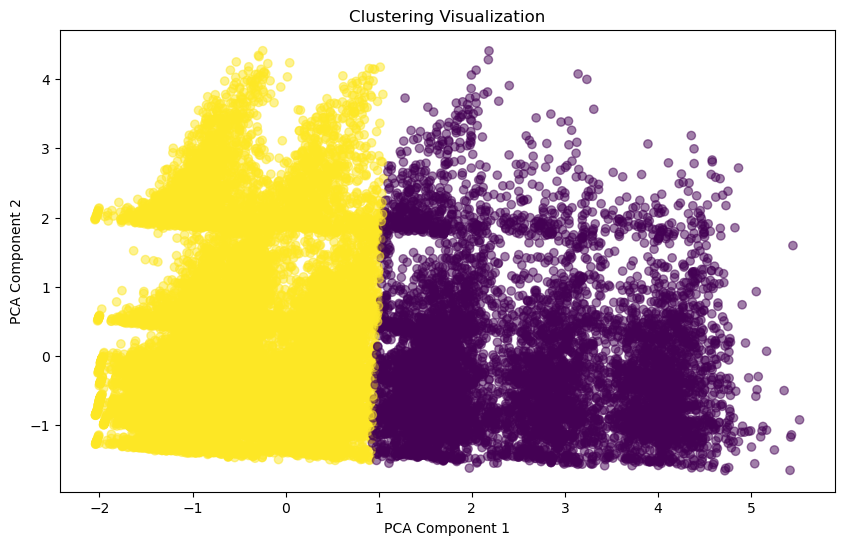

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
data['cluster'] = kmeans.fit_predict(features_pca)

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=data['cluster'], cmap='viridis', alpha=0.5)
plt.title("Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [10]:
from sklearn.metrics import pairwise_distances_argmin_min

# Calculate distances of each point to its cluster centroid
distances = pairwise_distances_argmin_min(features_pca, kmeans.cluster_centers_)[1]
data['distance_to_centroid'] = distances


In [11]:
# Define threshold as the 95th percentile of distances
threshold = np.percentile(distances, 90)

# Flag points as anomalies if their distance is above the threshold
data['is_anomaly'] = data['distance_to_centroid'] > threshold


In [12]:
from sklearn.model_selection import train_test_split

# Separate features and labels (use 'is_anomaly' as label for anomaly detection)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, data['is_anomaly'], test_size=0.3, random_state=42)


In [13]:
from sklearn.metrics import confusion_matrix, classification_report

# If the true labels are still available (replace `label` with actual column name if necessary)
y_true = data['label'].map({'CG': 1, 'OR': 0})  # Map CG to 1 and OR to 0
y_pred = data['is_anomaly'].astype(int)  # Convert boolean to int (1 for anomaly, 0 for normal)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))


Confusion Matrix:
 [[17935  2281]
 [18453  1763]]

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.89      0.63     20216
           1       0.44      0.09      0.15     20216

    accuracy                           0.49     40432
   macro avg       0.46      0.49      0.39     40432
weighted avg       0.46      0.49      0.39     40432



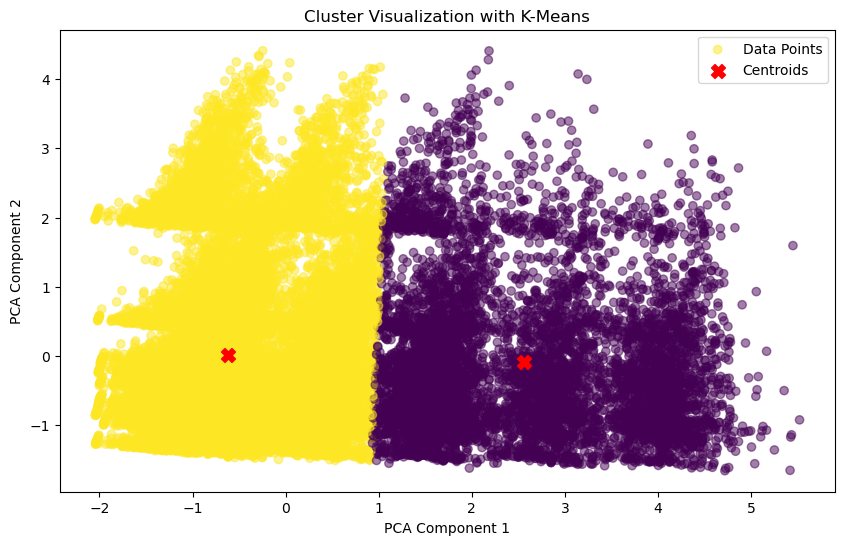

In [14]:
import matplotlib.pyplot as plt

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=data['cluster'], cmap='viridis', alpha=0.5, label='Data Points')

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100, label='Centroids')

plt.title("Cluster Visualization with K-Means")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


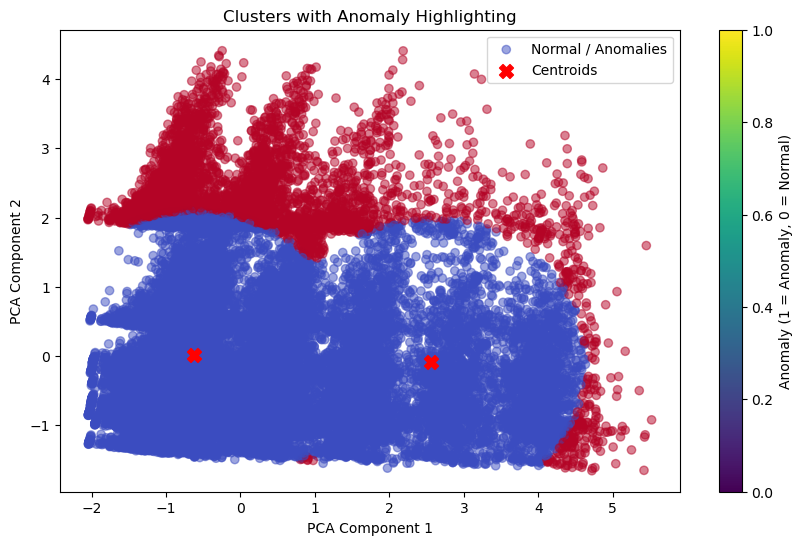

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=data['is_anomaly'], cmap='coolwarm', alpha=0.5, label='Normal / Anomalies')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100, label='Centroids')

plt.title("Clusters with Anomaly Highlighting")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Anomaly (1 = Anomaly, 0 = Normal)')
plt.legend()
plt.show()


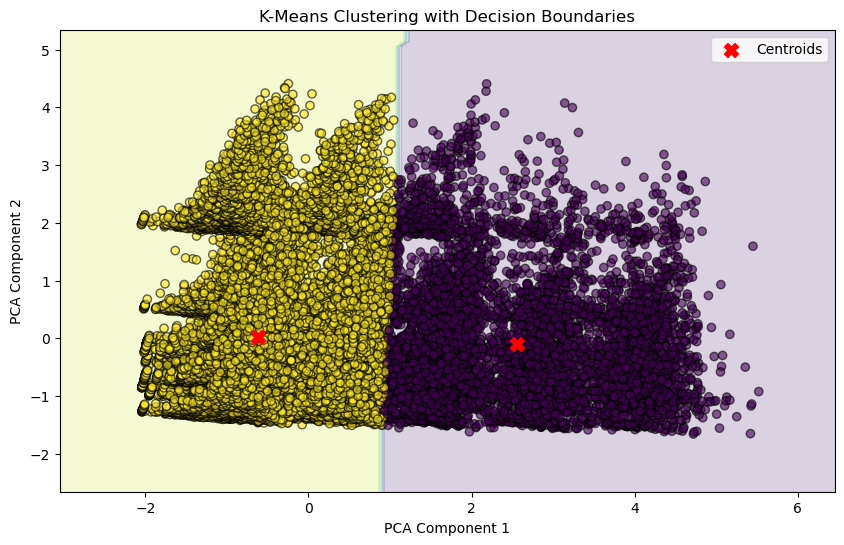

In [16]:
import numpy as np

# Define mesh grid
x_min, x_max = features_pca[:, 0].min() - 1, features_pca[:, 0].max() + 1
y_min, y_max = features_pca[:, 1].min() - 1, features_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict cluster for each point in mesh grid
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.2)

# Plot data points and centroids
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=data['cluster'], cmap='viridis', alpha=0.6, edgecolor='k')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100, label='Centroids')

plt.title("K-Means Clustering with Decision Boundaries")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000)  # Limit features for performance

# Transform the text column into TF-IDF features
tfidf_features = vectorizer.fit_transform(data['text_']).toarray()


In [18]:
from sklearn.cluster import KMeans

# Set number of clusters (try 2 for OR vs CG or experiment with other values)
kmeans = KMeans(n_clusters=2, random_state=42)
data['word_cluster'] = kmeans.fit_predict(tfidf_features)


In [19]:
from sklearn.metrics import confusion_matrix, classification_report

# Map OR to 0 and CG to 1 (or vice versa) if necessary
data['label'] = data['label'].map({'OR': 0, 'CG': 1})  # Convert labels for comparison

# Evaluate clustering performance against OR vs CG labels
conf_matrix = confusion_matrix(data['label'], data['word_cluster'])
print("Confusion Matrix:\n", conf_matrix)

# Classification report
print("\nClassification Report:\n", classification_report(data['label'], data['word_cluster']))


Confusion Matrix:
 [[16788  3428]
 [15675  4541]]

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.83      0.64     20216
           1       0.57      0.22      0.32     20216

    accuracy                           0.53     40432
   macro avg       0.54      0.53      0.48     40432
weighted avg       0.54      0.53      0.48     40432



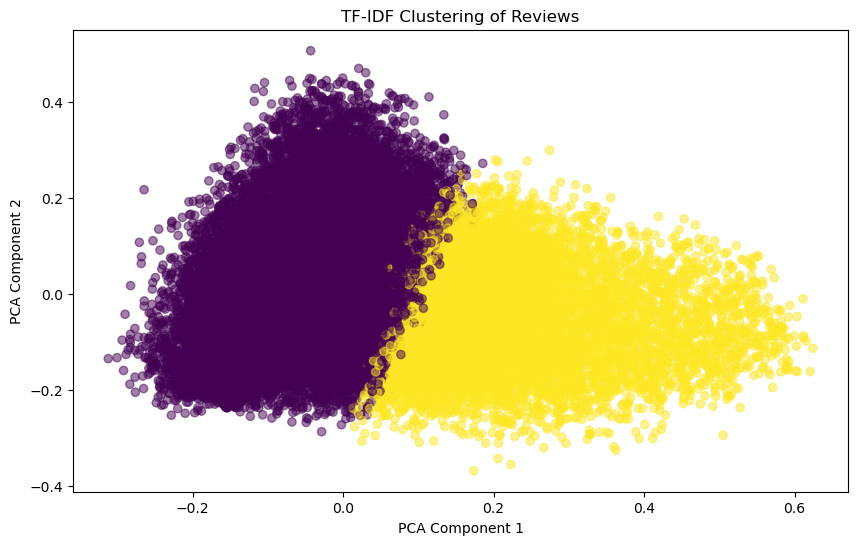

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
tfidf_features_pca = pca.fit_transform(tfidf_features)

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(tfidf_features_pca[:, 0], tfidf_features_pca[:, 1], c=data['word_cluster'], cmap='viridis', alpha=0.5)
plt.title("TF-IDF Clustering of Reviews")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
